### **DATASET OVERVIEW**

1. **ID**: the individual’s patient ID.  
2. **Registration Date**: the individual’s registration date at the hospital.  
3. **Drug**: type of drug given to the individual (D-penicillamine or placebo).  
4. **Birth Date**: the birth date of the individual.  
5. **Gender**: the gender of the individual.  
6. **Ascites**: presence of ascites (Y/N).  
7. **Hepatomegaly**: presence of hepatomegaly (Y/N).  
8. **Edema**: presence of edema (N = no edema, S = edema without diuretics, Y = edema despite diuretic
therapy).  
9. **Bilirubin**: serum bilirubin (mg/dL).  
10. **Cholesterol**: serum cholesterol (mg/dL).  
11. **Albumin**: amount of albumin (g/dL).  
12. **Copper**: amount of copper found in urine (μg/day).  
13. **Alkaline Phospatase (U/L)**: alkaline phosphatase (U/L).  
14. **SGOT**: Serum Glutamic-Oxaloacetic Transaminase (U/mL).  
15. **Tryglicerides**: Amount of triglycerides (mg/dL).  
16. **Platelets**: Platelets per cubic (mL/1000).  
17. **Prothrombin**: Prothrombin time (s).  
18. **Stage**: Histologic stage of the cirrhosis.

### **LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### **DATA PREPROCESSING AND EXPLORATORY DATA ANALYSIS**

During the Data Preprocessing and EDA, I performed cardinality check for each variables, dropping unnecessary columns, engineered the **Age** column from **Birth Date**, transforming data from the Drug and Stage columns to ensure their consistency, handled duplicates and missing values, and visualized data distributions.

#### **Read Dataset and Dataset Exploration**

In [ ]:
data = pd.read_csv("1A.tsv",
                   sep = "\t")
data.head()

,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


In [ ]:
print("Dataset Information:")
data.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       31

Based on the output above, it is known that the cirrhosis dataset contains of 418 observations and 18 columns.  
However, as **ID** is a unique-identifier column, it is unneccesary for our analysis, so we can simply drop it.

#### **Cardinality Check**

In [ ]:
cardinal = pd.DataFrame({
    "column name": data.columns.tolist(),
    "data type": [data[c].dtype for c in data.columns],
    "unique values": [data[c].nunique() for c in data.columns]
})
print("Cardinality Check Result:")
cardinal

Cardinality Check Result:


,column name,data type,unique values
0,ID,int64,418
1,Registration Date,object,399
2,Drug,object,5
3,Birth Date,object,344
4,Gender,object,2
5,Ascites,object,2
6,Hepatomegaly,object,2
7,Edema,object,3
8,Bilirubin,float64,98
9,Cholesterol,float64,69


Based on the cardinality check above, there are some columns that will not be necessary for the analysis:  
- **ID**, since it is the unique identifier, meaning that each entry has its own ID, so it won't give any specific insight for the model.
- **Registration Date**, since its unique value count is 399/418 entries, meaning that it is almost unique for each entries, just like ID.
- **Birth Date**, since its unique value count is 344/418 entries, meaning that it is also almost unique for each entries. However, this column can be used to create a new feature, namely **Age**, so we will perform feature engineering first before dropping this column.

#### **Feature Engineering : Age**

In [ ]:
# Transform Birth Date to Date
data["Birth Date"] = pd.to_datetime(data["Birth Date"],
                                    format = "%Y/%m/%d")
print("Birth Date Column transformed to Date.")

Birth Date Column transformed to Date.


In [ ]:
# Create Age Column
data["Age"] = 2025 - data["Birth Date"].dt.year
print("Age Column Created.")

Age Column Created.


In [ ]:
# Check
data["Age"]

,Age
0,59
1,57
2,71
3,55
4,39
...,...
413,68
414,40
415,58
416,59


#### **Drop Unnecessary Columns**

In [ ]:
columns = ["ID", "Registration Date", "Birth Date"]
for c in columns:
  data = data.drop(columns = c)
  print(f"Dropped column {c}.")

Dropped column ID.
Dropped column Registration Date.
Dropped column Birth Date.


In [ ]:
# Recheck
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       312 non-null    object 
 1   Gender                     418 non-null    object 
 2   Ascites                    312 non-null    object 
 3   Hepatomegaly               312 non-null    object 
 4   Edema                      418 non-null    object 
 5   Bilirubin                  418 non-null    float64
 6   Cholesterol                80 non-null     float64
 7   Albumin                    418 non-null    float64
 8   Copper                     310 non-null    float64
 9   Alkaline Phospatase (U/L)  312 non-null    float64
 10  SGOT                       312 non-null    float64
 11  Tryglicerides              418 non-null    float64
 12  Platelets                  407 non-null    float64
 13  Prothrombin                416 non-null    float64

Here, we have dropped the unnecessary columns, leaving us with 418 entries and 16 columns for our model.

#### **Divide Categorical and Numerical Columns**

In [ ]:
categorical = []
numerical = []

for i in data.columns:
  if 'int' in str(data[i].dtype) or 'float' in str(data[i].dtype):
    numerical.append(i)
  else:
    categorical.append(i)

categorical_wo_y = categorical.copy()
categorical_wo_y.remove("Stage")
print(f"Categorical columns: {categorical}")
print(f"Numerical columns: {numerical}")

Categorical columns: ['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
Numerical columns: ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age']


#### **Data Transformation**

In [ ]:
# Check Unique Values from Each Categorical Column
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Drug
D-penicillamine    155
Placebo            152
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64 

Gender
F    374
M     44
Name: count, dtype: int64 

Ascites
N    288
Y     24
Name: count, dtype: int64 

Hepatomegaly
Y    160
N    152
Name: count, dtype: int64 

Edema
N    354
S     44
Y     20
Name: count, dtype: int64 

Stage
stage_3    155
Stage4     144
Stage 2     92
Stage 1     21
Name: count, dtype: int64 



Based on the output above, there are some inconsistencies in **Drug** and **Stage** columns.

In [ ]:
# Standardize Drug Column
data["Drug"] = data["Drug"].str.title()
data["Drug"] = data["Drug"].replace("Lacebo", "Placebo")
print("Drug column standardized.")

Drug column standardized.


In [ ]:
# Standardize Stage Column
data["Stage"] = data["Stage"].str.extract('(\d+)',
                                          expand = False)
print("Stage column standardized.")

Stage column standardized.


In [ ]:
# Recheck
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Drug
D-Penicillamine    158
Placebo            154
Name: count, dtype: int64 

Gender
F    374
M     44
Name: count, dtype: int64 

Ascites
N    288
Y     24
Name: count, dtype: int64 

Hepatomegaly
Y    160
N    152
Name: count, dtype: int64 

Edema
N    354
S     44
Y     20
Name: count, dtype: int64 

Stage
3    155
4    144
2     92
1     21
Name: count, dtype: int64 



#### **Handle Duplicates**

In [ ]:
# Check Duplicates
print(f"There are {data.duplicated().sum()} duplicates.")

There are 0 duplicates.


In [ ]:
# Drop Duplicates
data = data.drop_duplicates().reset_index(drop = True)
print(f"Duplicates dropped.")

Duplicates dropped.


#### **Handle Missing Values**

In [ ]:
# Check Missing Values
missing = pd.DataFrame({
    "column name" : data.columns.tolist(),
    "missing values": data.isnull().sum().tolist(),
    "percentage": ((data.isnull().sum()) * 100 / len(data)).tolist()
})

print("Missing Values Check Result:")
missing

Missing Values Check Result:


,column name,missing values,percentage
0,Drug,106,25.358852
1,Gender,0,0.000000
2,Ascites,106,25.358852
3,Hepatomegaly,106,25.358852
4,Edema,0,0.000000
5,Bilirubin,0,0.000000
6,Cholesterol,338,80.861244
7,Albumin,0,0.000000
8,Copper,108,25.837321
9,Alkaline Phospatase (U/L),106,25.358852


Based on the missing values check result above, there are some columns that we need to pay attention to:
- **Prothrombin**, contains 0.48% missing values, so we will impute the values.
- **Stage**, contains 1.44% missing values, we will drop the missing observations because this is the target variable.
- **Platelets**, contains 2.63% missing values, we will impute the values.
- **Drug**, contains 25.36% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **Ascites**, contains 25.36% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **Hepatomegaly**, contains 25.36% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **Alkaline Phospatase (U/L)**, contains 25.36% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **SGOT**, contains 25.36% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **Copper**, contains 25.84% missing values, imputing it will cause bias on the analysis. Hence, we will drop the missing observations.
- **Cholesterol**, contains 80.86% missing values, imputing it will cause bias on the analysis. However, dropping the missing observations will cause lack of observations for our model. So, we will drop the column.

In [ ]:
# Drop Missing Values Observatiosn
drops = ["Drug", "Ascites", "Hepatomegaly", "Alkaline Phospatase (U/L)", "SGOT", "Copper"]
data = data.dropna(subset = drops).reset_index(drop = True)
print("Missing Observations dropped.")

Missing Observations dropped.


In [ ]:
# Recheck Missing Values
missing = pd.DataFrame({
    "column name" : data.columns.tolist(),
    "missing values": data.isnull().sum().tolist(),
    "percentage": ((data.isnull().sum()) * 100 / len(data)).tolist()
})

print("Missing Values Check Result:")
missing

Missing Values Check Result:


,column name,missing values,percentage
0,Drug,0,0.000000
1,Gender,0,0.000000
2,Ascites,0,0.000000
3,Hepatomegaly,0,0.000000
4,Edema,0,0.000000
5,Bilirubin,0,0.000000
6,Cholesterol,230,74.193548
7,Albumin,0,0.000000
8,Copper,0,0.000000
9,Alkaline Phospatase (U/L),0,0.000000


After we dropped some of the observations, we got 1.29% missing values on the **Platelets** column and 74.19% missing values on the **Cholesterol** column.

In [ ]:
# Drop Cholesterol Column
data = data.drop(columns = ["Cholesterol"])
numerical.remove("Cholesterol")
print(f"Dropped column Cholesterol.")

Dropped column Cholesterol.


In [ ]:
# Impute Values for Platelets
data.loc[data["Platelets"].isna(), "Platelets"] = data["Platelets"].dropna().median()
print(f"Missing values imputed.")

Missing values imputed.


In [ ]:
# Recheck Missing Values
missing = pd.DataFrame({
    "column name" : data.columns.tolist(),
    "missing values": data.isnull().sum().tolist(),
    "percentage": ((data.isnull().sum()) * 100 / len(data)).tolist()
})

print("Missing Values Check Result:")
missing

Missing Values Check Result:


,column name,missing values,percentage
0,Drug,0,0.0
1,Gender,0,0.0
2,Ascites,0,0.0
3,Hepatomegaly,0,0.0
4,Edema,0,0.0
5,Bilirubin,0,0.0
6,Albumin,0,0.0
7,Copper,0,0.0
8,Alkaline Phospatase (U/L),0,0.0
9,SGOT,0,0.0


Here, we have handled all of the missing values.

#### **Distribution Check**

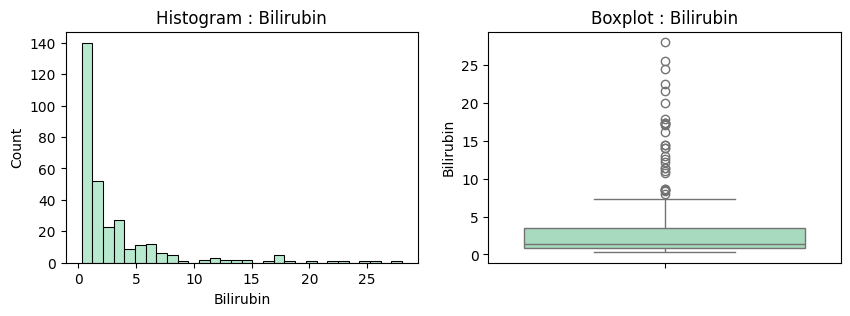

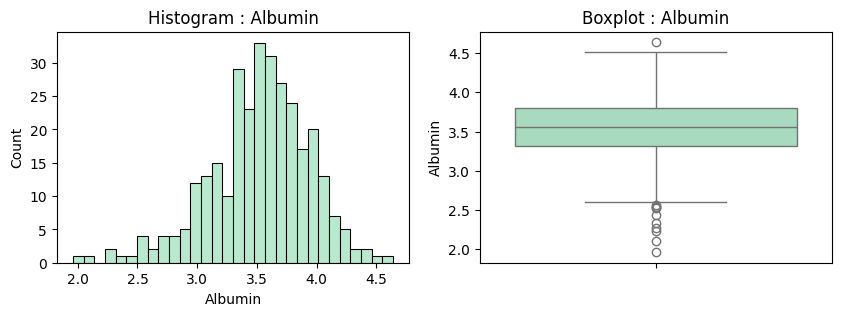

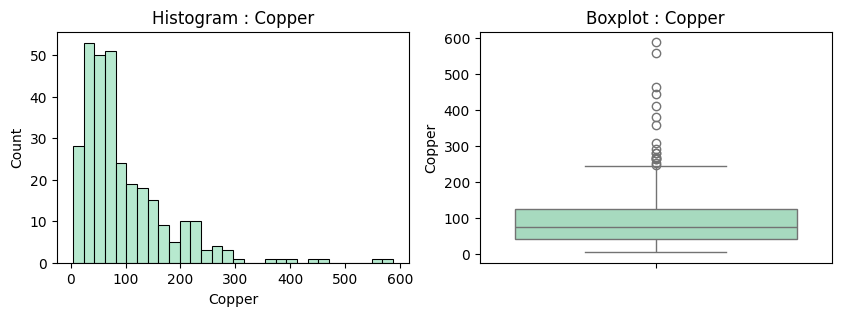

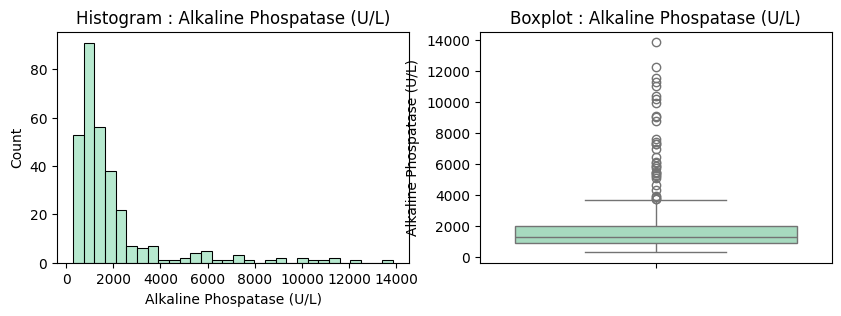

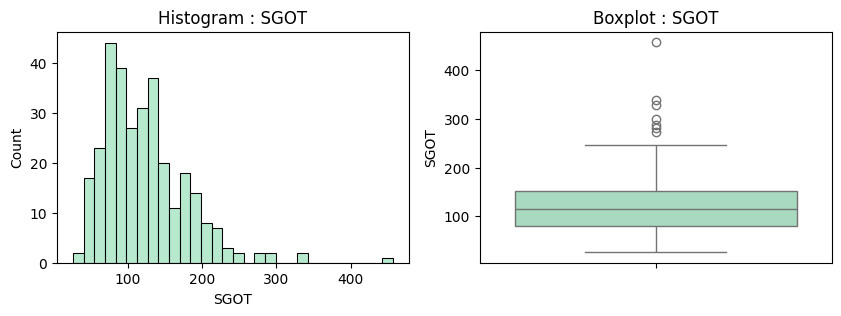

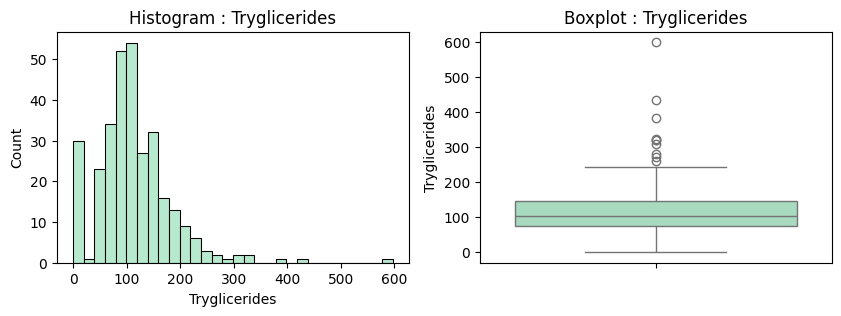

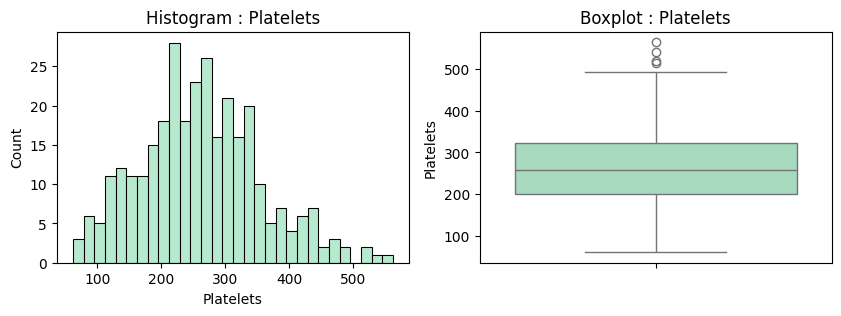

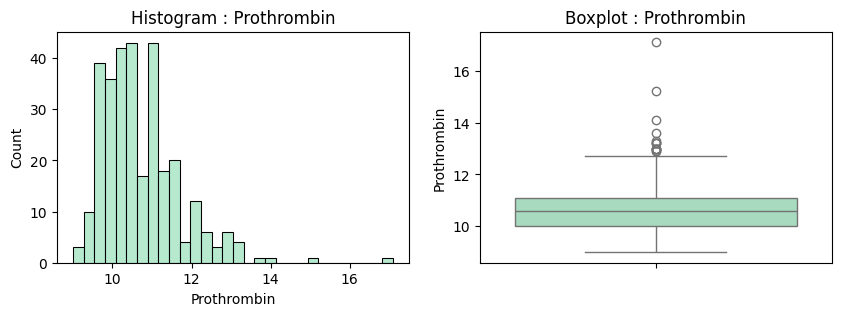

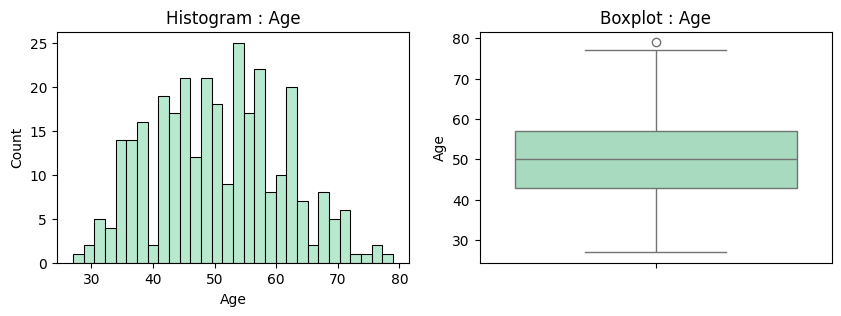

In [ ]:
# Numerical Columns
def dist_check(df, columns):
  for c in columns:
    plt.figure(figsize = (10, 3))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[c],
                 bins = 30,
                 color = "#9FE2BF")
    plt.title(f"Histogram : {c}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y = df[c],
                color = "#9FE2BF")
    plt.title(f"Boxplot : {c}")

    plt.show()

dist_check(data, numerical)

From the distribution check above, there are many outliers from each column of the data. However, since our dataset is very small, and considering that they are realistic in a medical context, we won't be performing any outlier handling.  
Additionally, since there are several outliers in each numerical column, we will be scaling it using RobustScaler later.

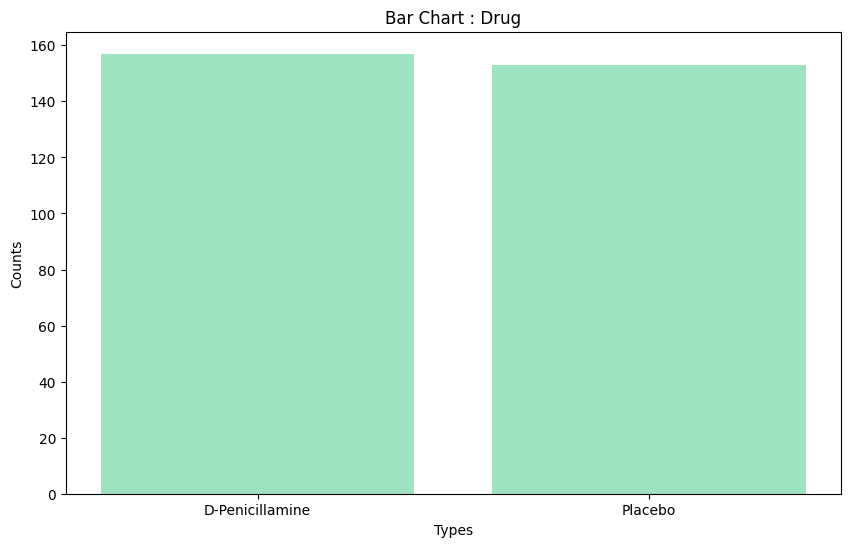

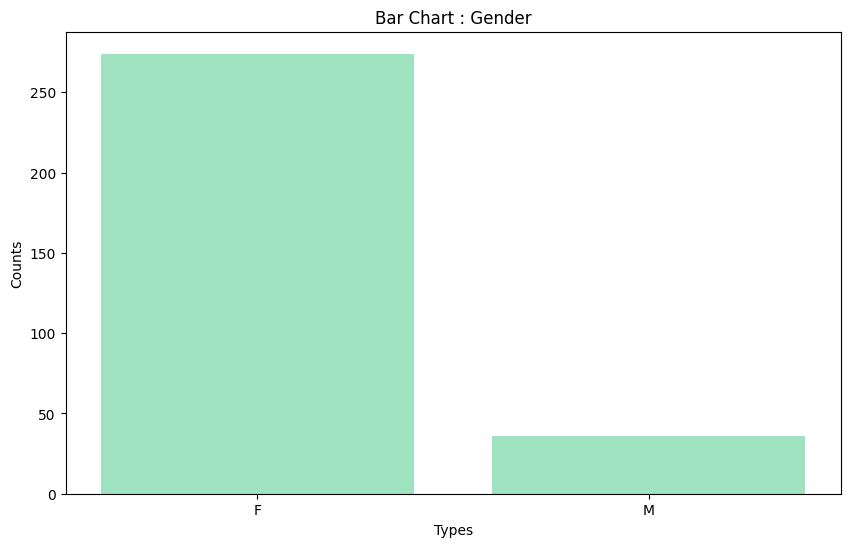

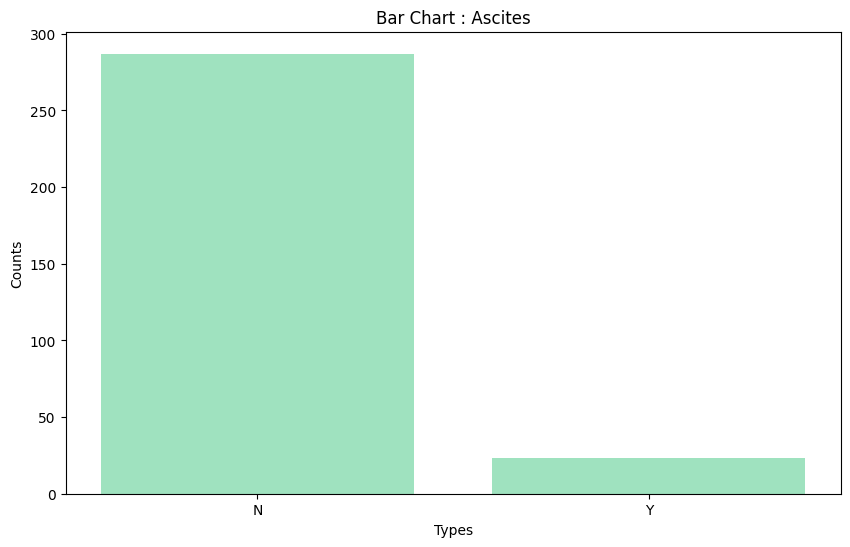

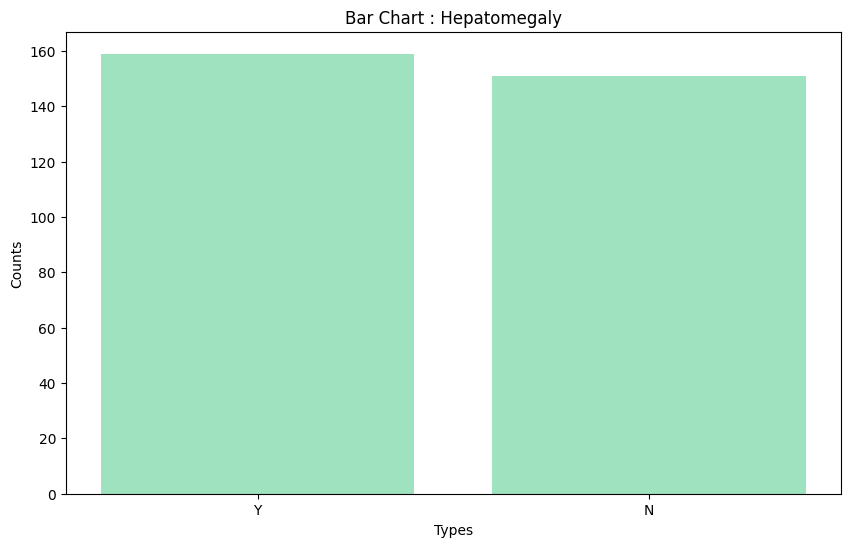

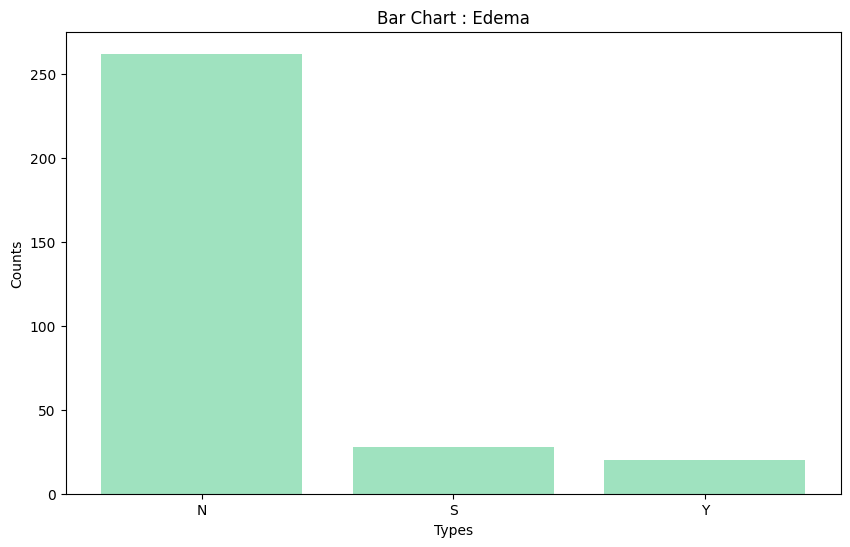

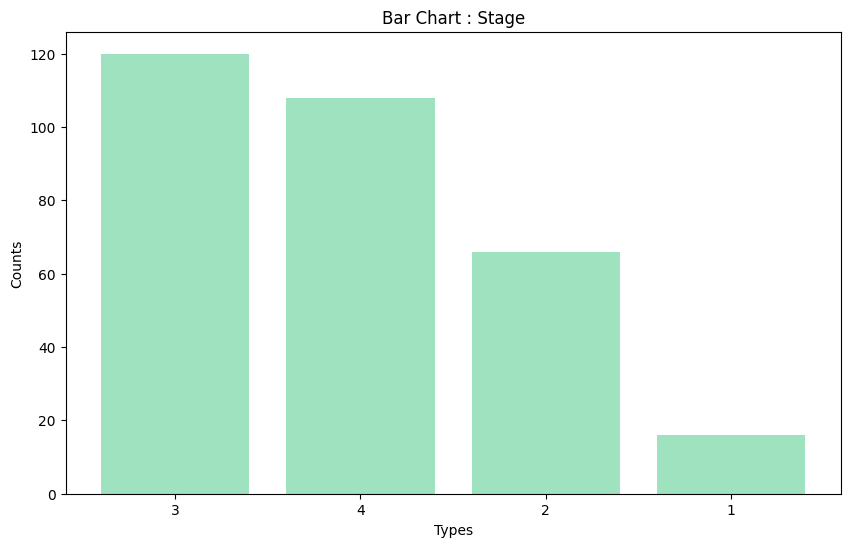

In [ ]:
# Categorical Columns
def categorical_dist(df, columns):
  for c in columns:
    plt.figure(figsize = (10, 6))

    plt.bar(x = data[c].value_counts().index,
            height = data[c].value_counts().values,
            color = "#9FE2BF")
    plt.title(f"Bar Chart : {c}")
    plt.xlabel("Types")
    plt.ylabel("Counts")

    plt.show()

categorical_dist(data, categorical)

Based on the plots above, we can get some informations:
- **Gender**: Majority of the patients are female.
- **Ascites**: Most of the patients have no ascites.
- **Edema**: Most of the patients have no edema.

However, there are some imbalances in the **Gender**, **Ascites**, **Edema**, and **Stage** columns. These imbalances on the target variable (**Stage**) might contribute to bias and will be considered if the models perform poorly later on.

#### **Encoding**

In [ ]:
# Display Unique Values from Each Categorical Column
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Drug
D-Penicillamine    157
Placebo            153
Name: count, dtype: int64 

Gender
F    274
M     36
Name: count, dtype: int64 

Ascites
N    287
Y     23
Name: count, dtype: int64 

Hepatomegaly
Y    159
N    151
Name: count, dtype: int64 

Edema
N    262
S     28
Y     20
Name: count, dtype: int64 

Stage
3    120
4    108
2     66
1     16
Name: count, dtype: int64 



Based on the output above, we will use Binary Encoder for **Drug**, **Gender**, **Ascites**, and **Hepatomegaly** columns, and Ordinal Encoder for the **Edema** and **Stage** column.

In [ ]:
# Binary Encode
binary_enc = {
    "Drug": {
        "D-Penicillamine": 0,
        "Placebo": 1
    },
    "Gender": {
        "M": 0,
        "F": 1
    },
    "Ascites": {
        "N": 0,
        "Y": 1
    },
    "Hepatomegaly": {
        "N": 0,
        "Y": 1
    }
}
data = data.replace(binary_enc)
print(f"Binary Encode performed.")

Binary Encode performed.


<ipython-input-26-7a5dfe4b459f>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(binary_enc)


In [ ]:
# Ordinal Encode
ord_enc = {
    "Edema": {
        "N": 0,
        "S": 1,
        "Y": 2
    },
    "Stage": {
        "1": 0,
        "2": 1,
        "3": 2,
        "4": 3
    }
}
data = data.replace(ord_enc)
print(f"Ordinal Encode performed.")

Ordinal Encode performed.


<ipython-input-27-7e1509eac6fb>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(ord_enc)


In [ ]:
# Recheck
for c in categorical:
  print(data[c].value_counts(),
        '\n')

Drug
0    157
1    153
Name: count, dtype: int64 

Gender
1    274
0     36
Name: count, dtype: int64 

Ascites
0    287
1     23
Name: count, dtype: int64 

Hepatomegaly
1    159
0    151
Name: count, dtype: int64 

Edema
0    262
1     28
2     20
Name: count, dtype: int64 

Stage
2    120
3    108
1     66
0     16
Name: count, dtype: int64 



Here, we have encoded all of the categorical column to numerical form.

#### **Check Variables Correlation with Y Variable**

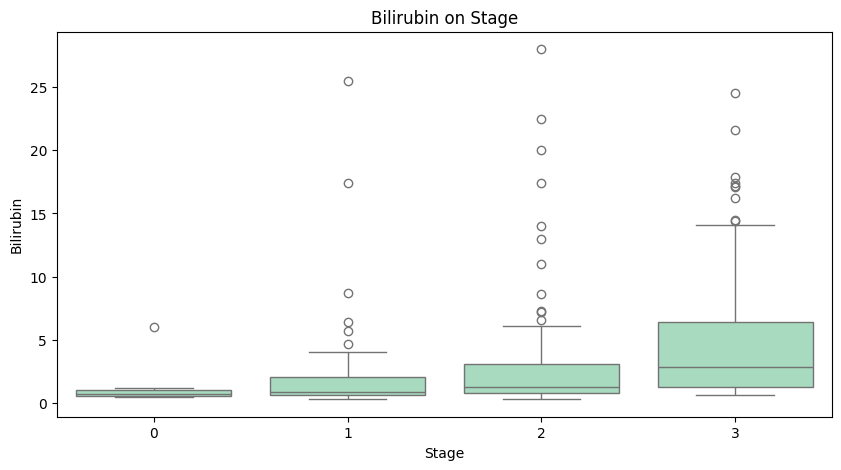

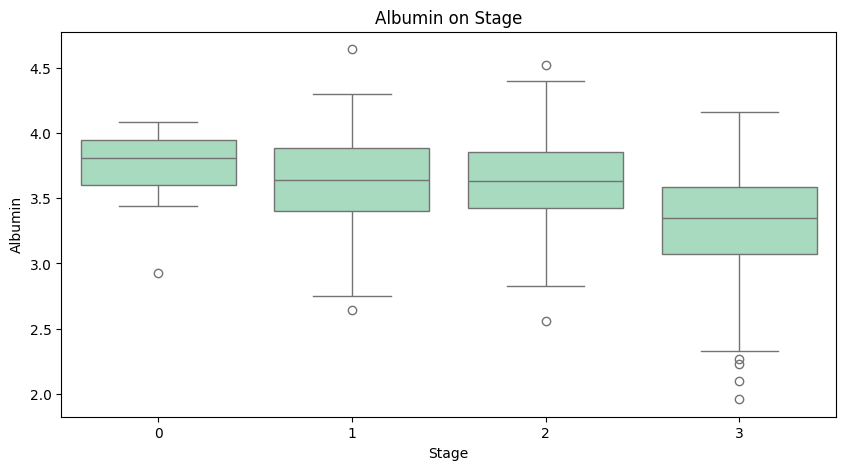

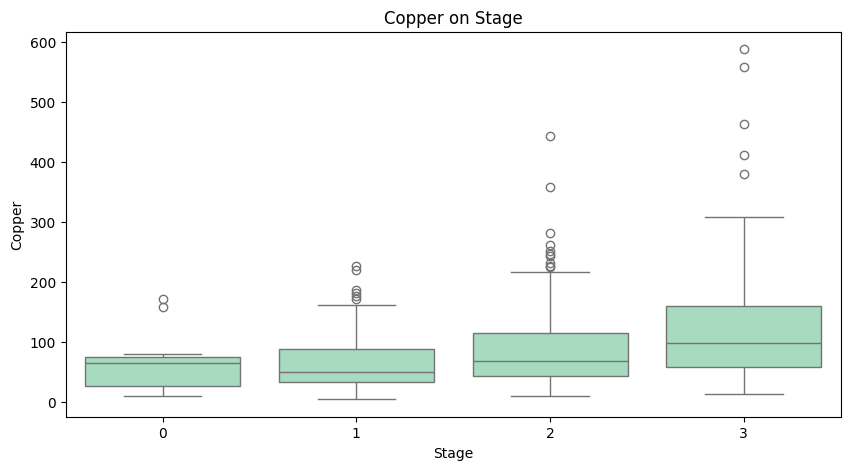

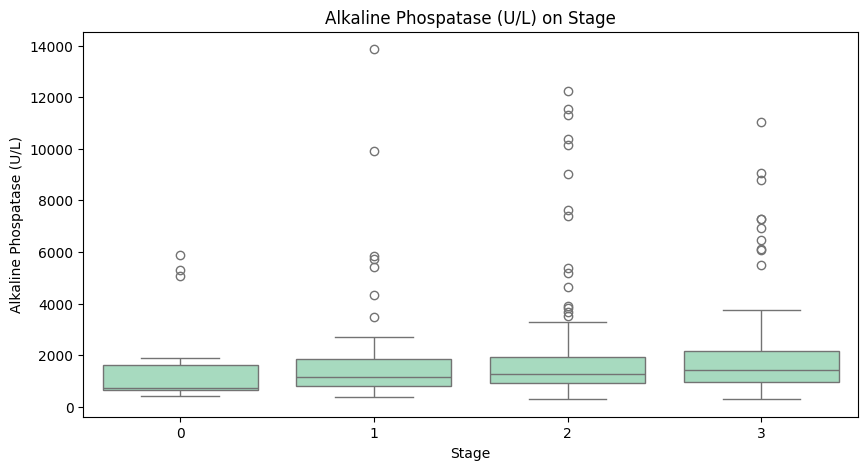

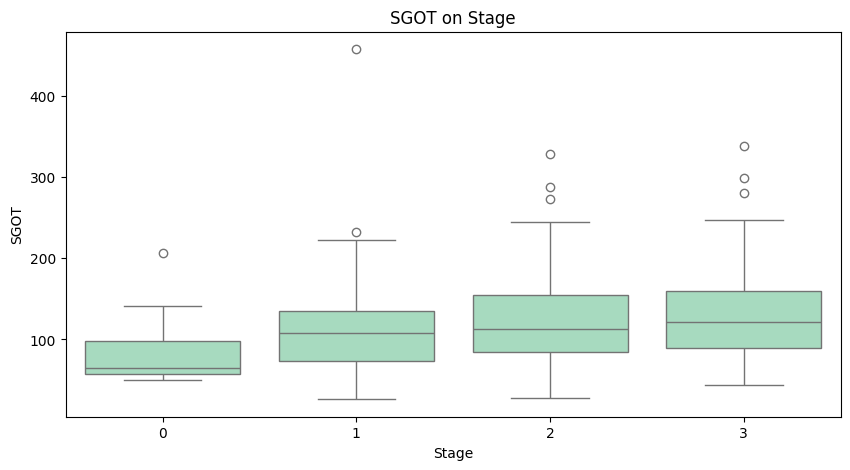

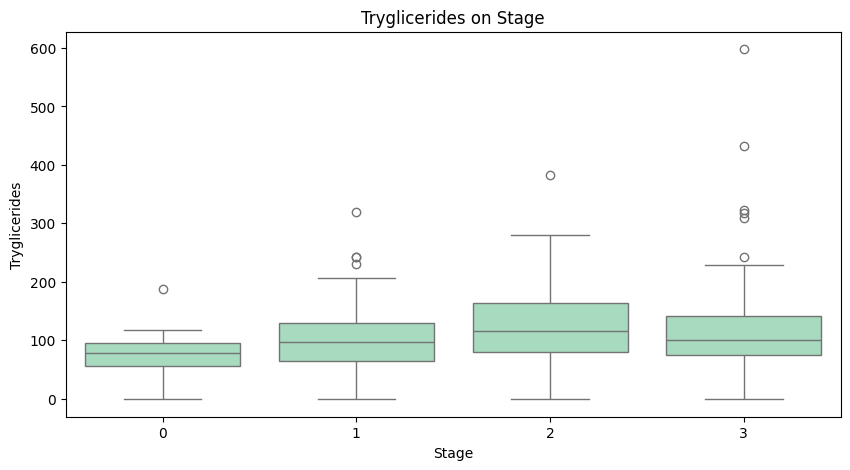

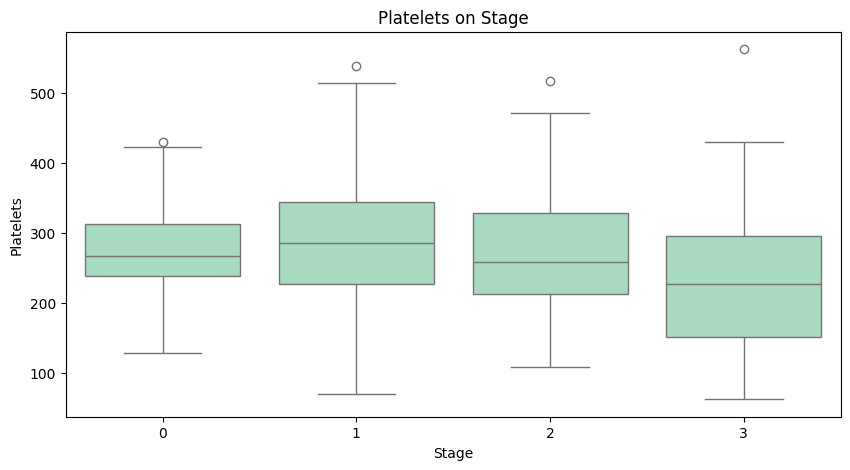

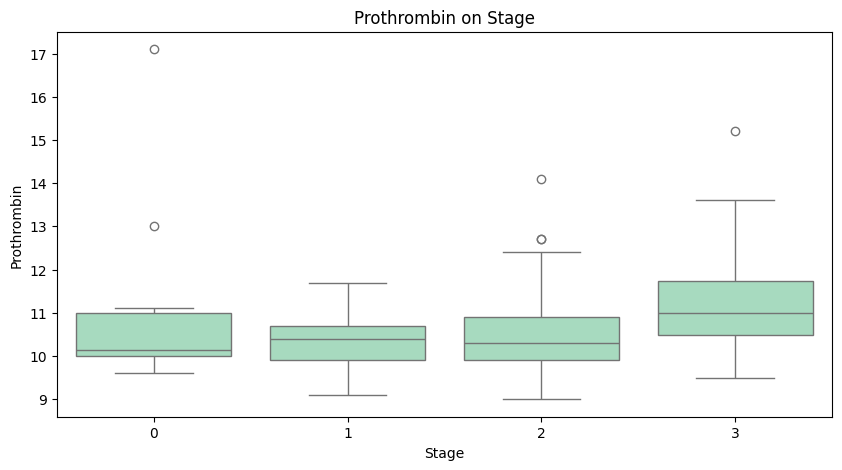

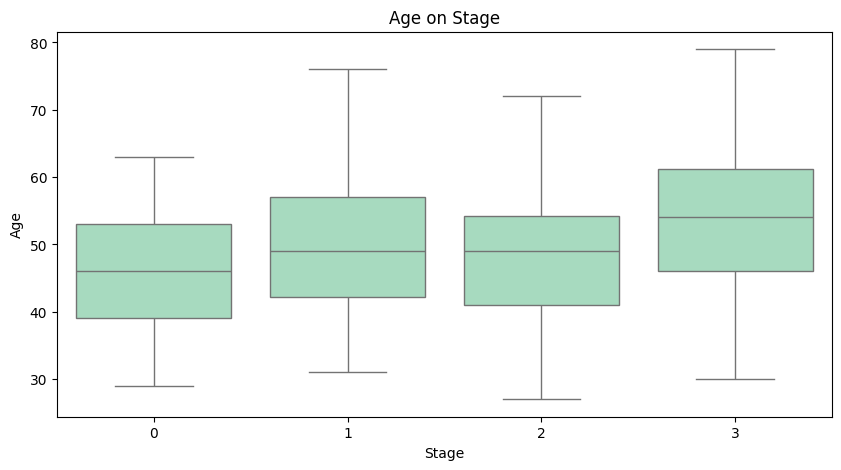

In [ ]:
def num_with_y(data, cols, target, target_order):
  for c in cols:
    plt.figure(figsize = (10, 5))

    sns.boxplot(x = data[target],
                y = data[c],
                order = target_order,
                color = "#9FE2BF")
    plt.title(f"{c} on {target}")

    plt.show()

num_with_y(data,
           numerical,
           "Stage",
           target_order = ["0", "1", "2", "3"])

Based on the plots above:
- **Bilirubin**: Patients with higher stages of cirrhosis tend to have higher average bilirubin serum levels.
- **Albumin**: The higher the stage of patient's cirrhosis, the lower the amount of albumin.
- **SGOT**: Stage 0 patients have the lowest dosis of Serum Glutamic-Oxaloacetic Transaminase, while stage 4 patients has the highest dosis.
- **Age**: Stage 4 patients are generally older compared to other stages.

As a conclusion, **Bilirubin**, **Albumin**, **SGOT**, and **Age** can be identified as slightly significant to determine the **Stage**, while the others aren't really significant.

<Figure size 1000x500 with 0 Axes>

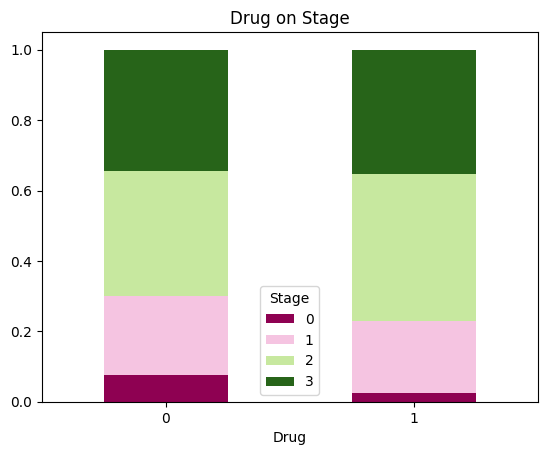

<Figure size 1000x500 with 0 Axes>

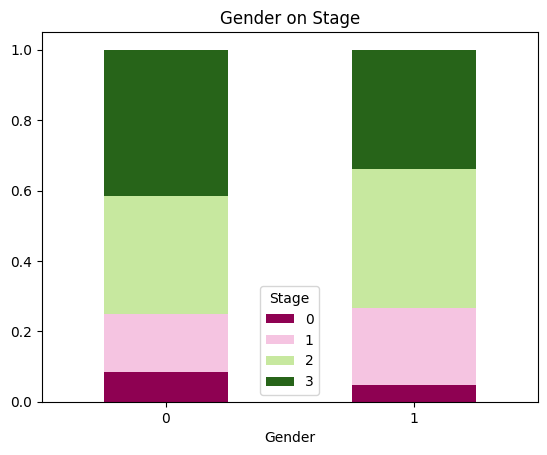

<Figure size 1000x500 with 0 Axes>

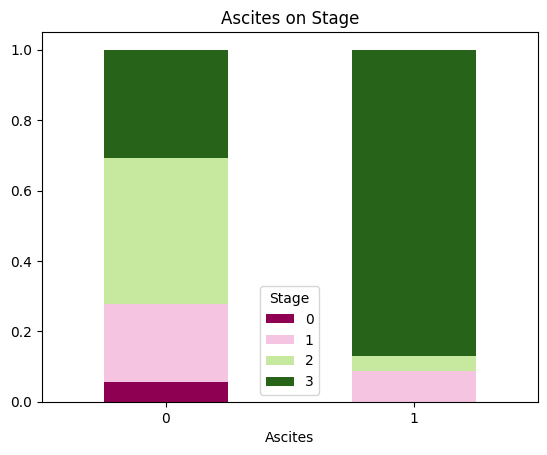

<Figure size 1000x500 with 0 Axes>

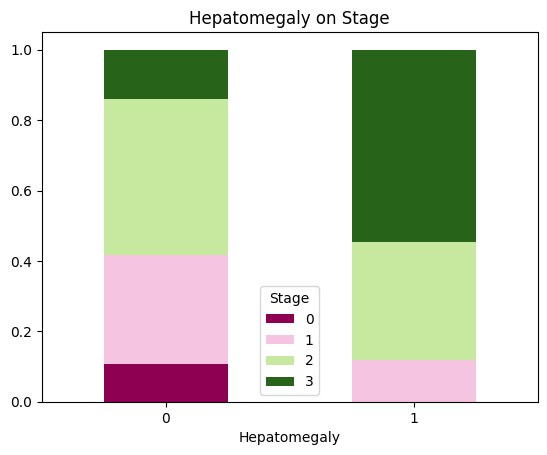

<Figure size 1000x500 with 0 Axes>

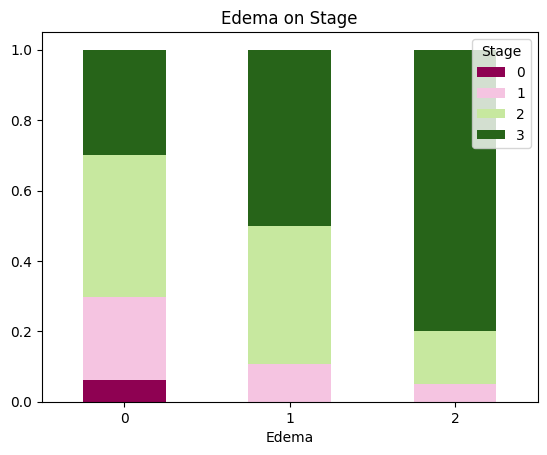

In [ ]:
def cat_with_y(data, cols, target):
  for c in cols:
    plt.figure(figsize = (10, 5))

    data.groupby(c)[target].value_counts(normalize = True).unstack(target).plot.bar(stacked = True,
                                                                                    cmap = "PiYG")
    plt.title(f"{c} on {target}")
    plt.xticks(rotation = 0)

    plt.show()

cat_with_y(data,
           categorical_wo_y,
           "Stage")

Based on the plots above:
- Ascites is predominantly detected in stage 4 patients.
- The presence of hepatomegaly is most commonly detected in stage 4 patients.
- More than 50% of patients with edema despite of diuretic therapy belong to stage 4.

As a conclusion, **Ascites**, **Hepatomegaly**, and **Edema** are significant towards the **Stage**, while the **Drug** and **Gender** doesn't really affect it.

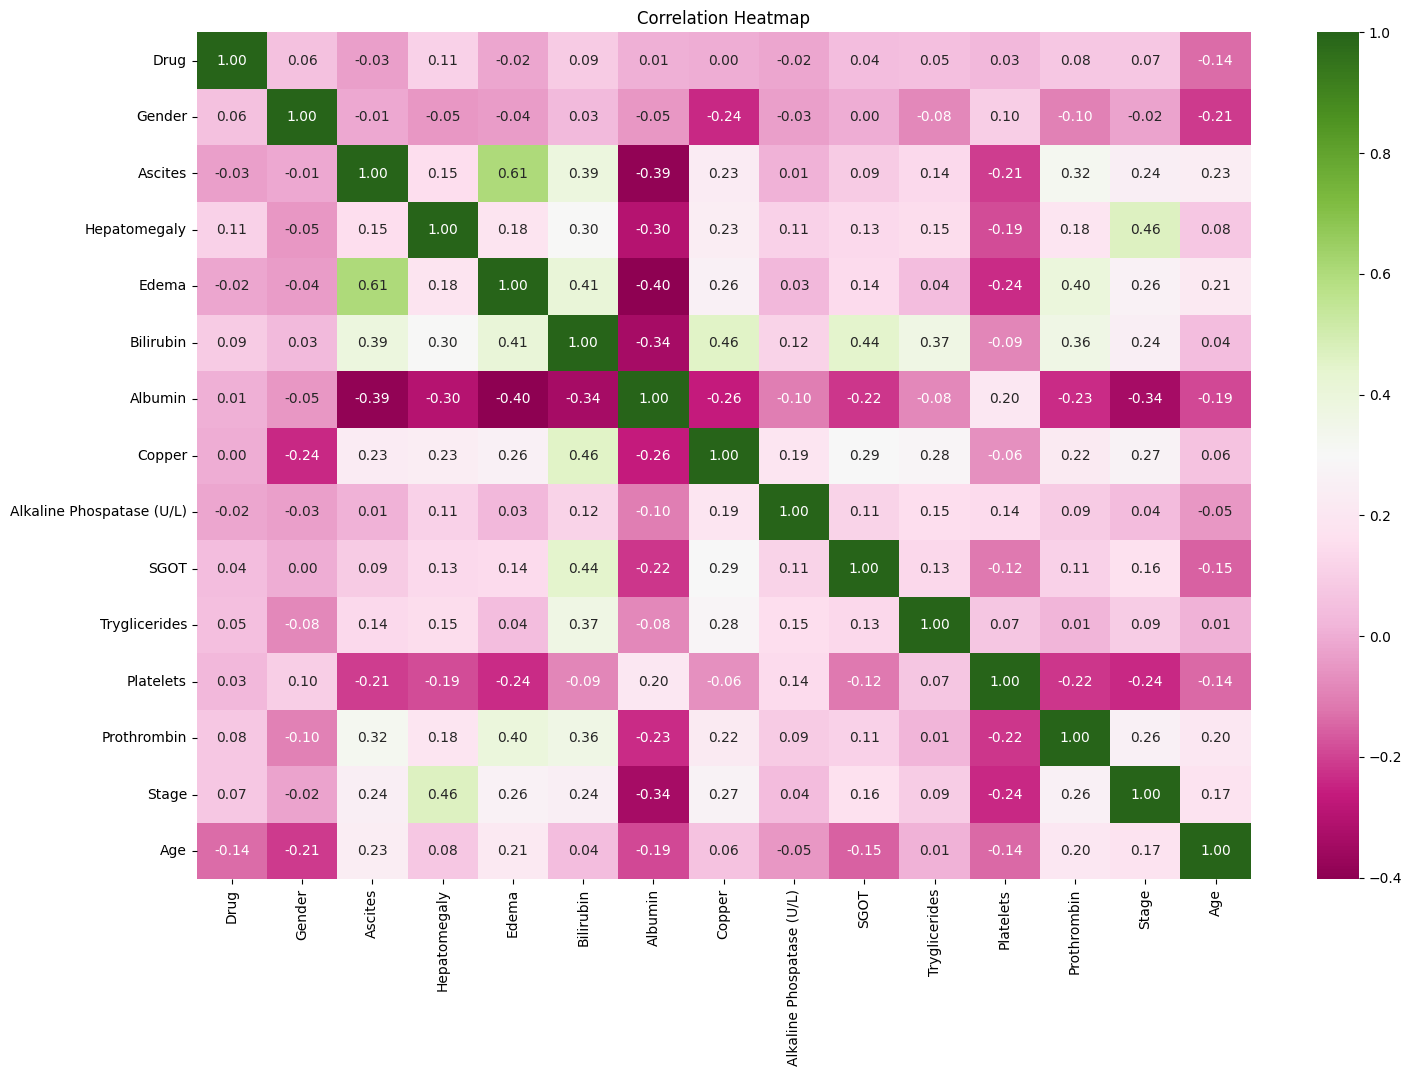

In [ ]:
def heatmap(data):
  plt.figure(figsize = (17, 11))

  sns.heatmap(data.corr(),
              annot = True,
              cmap = "PiYG",
              fmt = ".2f",
              cbar = True)
  plt.title("Correlation Heatmap")
  plt.xlabel("")
  plt.ylabel("")

  plt.show()

heatmap(data)

Based on the correlation heatmap displayed above, it is shown that **Drug**, **Gender**, **Alkaline Phospatase (U/L)**, **Tryglicerides** have less than 10% correlation with the **Stage**, and the most significant features are **Hepatomegaly** and **Albumin** (with more than 30% correlation).

### **MODELLING AND FINE TUNING**

#### **Data Splitting**

In [ ]:
x = data[data.columns.drop(["Stage"])]
y = data["Stage"]

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.4,
                                                    random_state = 11)

print("Data splitted.")

Data splitted.


#### **Scaling**

In [ ]:
robust = RobustScaler()
x_train[numerical] = robust.fit_transform(x_train[numerical])
x_test[numerical] = robust.transform(x_test[numerical])
print("Scaling performed.")

Scaling performed.


As mentioned before, we use RobustScaler because the numerical columns have some outliers, so RobustScaler is the best scaler to use.

#### **Modeling and Evaluation : Random Forest**

In [ ]:
# Modeling
model_rf = RandomForestClassifier(n_estimators = 70,
                                  max_depth = 7,
                                  min_samples_split = 7,
                                  criterion = "gini",
                                  random_state = 7)

model_rf.fit(x_train,
             y_train)
ypred_rf = model_rf.predict(x_test)
print("Random Forest Model.")

Random Forest Model.


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.67      0.15      0.25        26
           2       0.41      0.64      0.50        44
           3       0.61      0.65      0.63        46

    accuracy                           0.50       124
   macro avg       0.42      0.36      0.34       124
weighted avg       0.51      0.50      0.46       124

   0  1   2   3
0  0  0   8   0
1  0  4  18   4
2  0  1  28  15
3  0  1  15  30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


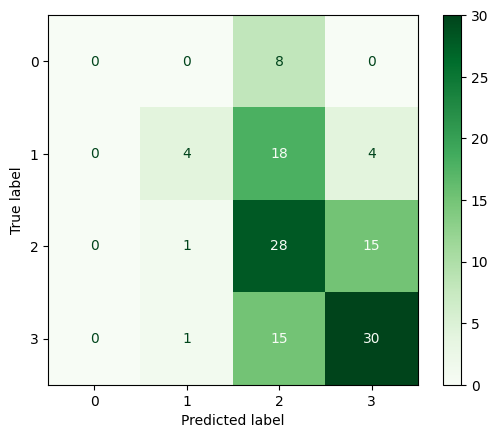

In [ ]:
# Evaluation
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_rf))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_rf)))
cm_rf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                   ypred_rf),
                               display_labels = model_rf.classes_)
cm_rf.plot(cmap = "Greens")

Based on the classification report above, the overall accuracy score of the Random Forest model is 50%, with 42% precision, 36% recall, and 34% f1-score. These scores indicates that the model is really bad at predicting the cirrhosis stages.  

The precision score shows that only 42% of the predicted positive values are truly positive, while the recall score shows that 36% of the positive values are actually predicted positive. As a result, the F1-Score shows that the model's performance is horrible.  

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
0   0   116 8
```
**Class 2**

```
TP  FP  TN  FN
4   2   96  22
```
**Class 3**

```
TP  FP  TN  FN
28  41  39  16
```
**Class 4**

```
TP  FP  TN  FN
30  19  59  16
```

Additionally, the confusion matrix also shows that the model's predictions are rather gambled than really predict the result, since the true values (62) and the false values (62) are balanced.

#### **Modeling and Evaluation : XGBoost**

In [ ]:
# Modeling
model_xgb = XGBClassifier(n_estimators = 70,
                          learning_rate = 0.7,
                          max_depth = 7,
                          eval_metric = "logloss")

model_xgb.fit(x_train,
              y_train)
ypred_xgb = model_xgb.predict(x_test)
print("XGBoost Model.")

XGBoost Model.


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.38      0.23      0.29        26
           2       0.42      0.64      0.51        44
           3       0.67      0.57      0.61        46

    accuracy                           0.49       124
   macro avg       0.45      0.39      0.40       124
weighted avg       0.50      0.49      0.48       124

   0  1   2   3
0  1  0   7   0
1  1  6  16   3
2  1  5  28  10
3  0  5  15  26


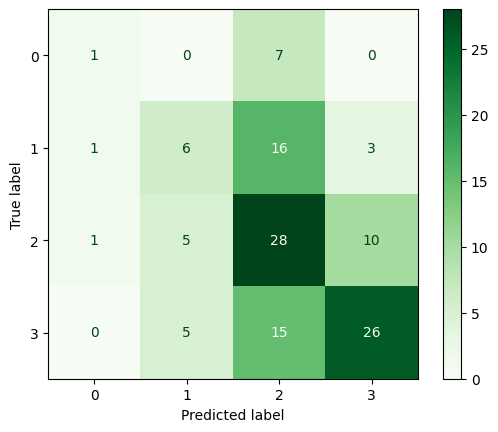

In [ ]:
# Evaluation
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_xgb))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_xgb)))
cm_xgb = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                    ypred_xgb),
                               display_labels = model_xgb.classes_)
cm_xgb.plot(cmap = "Greens")

Based on the classification report above, it shows that the model's accuracy is 49%, with 45% precision, 39% recall, and 40% f1-score.

These scores shows that the XGBoost model performs similarly with the Random Forest model to predict the cirrhosis stages, with only 45% of the predicted positive are truly positive, 39% of the positive values are predicted positive, and a balanced score of precision and recall, 40%.

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
1   2   114 7
```
**Class 2**

```
TP  FP  TN  FN
6   10  88  20
```
**Class 3**

```
TP  FP  TN  FN
28  38  42  16
```
**Class 4**

```
TP  FP  TN  FN
26  13  65  20
```

Furthermore, the confusion matrix with 61 true values and 63 false value indicates that the XGBoost model performs really bad.

#### **Fine Tuning : Random Forest**

In [ ]:
rf_hyparams = {
    "n_estimators": [11, 70, 110, 170],
    "max_depth": [7, 11, 17, 77],
    "min_samples_split": [7, 11, 17, 77],
    "criterion": ["gini"],
    "random_state": [7]
}

rf_ft = RandomForestClassifier()

grid_rf = GridSearchCV(estimator = rf_ft,
                       param_grid = rf_hyparams,
                       cv = 2,
                       n_jobs = -1)
grid_rf.fit(x_train,
            y_train)

print(f"Fine Tuning (Random Forest) Result:")
print(f"The best score : {grid_rf.best_score_}")
print(f"The best parameters : {grid_rf.best_params_}")

model_rfft = grid_rf.best_estimator_
model_rfft.fit(x_train,
               y_train)
ypred_rfft = model_rfft.predict(x_test)
print("Fine Tuned : Random Forest Model.")

Fine Tuning (Random Forest) Result:
The best score : 0.521505376344086
The best parameters : {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 17, 'n_estimators': 70, 'random_state': 7}
Fine Tuned : Random Forest Model.


Based on the fine tuning, the best parameters for the Random Forest Model are:
- criterion : "gini"
- max_depth = 7
- min_samples_split = 17
- n_estimators = 70

with the best score of 52%.

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      0.12      0.19        26
           2       0.45      0.75      0.56        44
           3       0.69      0.67      0.68        46

    accuracy                           0.54       124
   macro avg       0.43      0.38      0.36       124
weighted avg       0.54      0.54      0.49       124

   0  1   2   3
0  0  0   8   0
1  0  3  19   4
2  0  1  33  10
3  0  1  14  31


c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


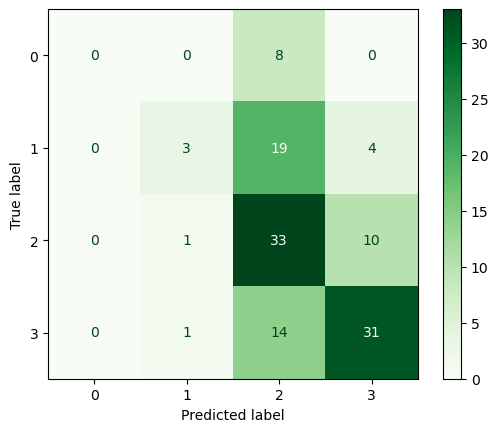

In [ ]:
# Evaluation
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_rfft))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_rfft)))
cm_rf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                   ypred_rfft),
                               display_labels = model_rfft.classes_)
cm_rf.plot(cmap = "Greens")

Based on the classification report above, the overall accuracy score of the fine-tuned Random Forest model is 54%, with 43% precision, 38% recall, and 36% f1-score. These scores indicates a slight improvement from the previous model, but the model still performed badly at predicting the cirrhosis stages.  

The precision score shows that only 43% of the predicted positive values are truly positive, while the recall score shows that 38% of the positive values are actually predicted positive. As a result, the F1-Score (36%) shows that the model's performance is horrible.  

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
0   0   116 8
```
**Class 2**

```
TP  FP  TN  FN
3   2   96  23
```
**Class 3**

```
TP  FP  TN  FN
33  41  39  11
```
**Class 4**

```
TP  FP  TN  FN
31  14  64  15
```

With the details provided above, the confusion matrix also shows that the model's predictions are rather gambled than really predict the result, since the true values (67) and the false values (57) are balanced.

#### **Fine Tuning : XGBoost**

In [ ]:
xgb_hyparams = {
    "n_estimators": [11, 70, 110, 170],
    "learning_rate": [0.11, 0.35, 0.7, 0.9],
    "max_depth": [7, 11, 17, 77],
    "eval_metric": ["logloss"]
}

xgb_ft = XGBClassifier()

grid_xgb = GridSearchCV(estimator = xgb_ft,
                        param_grid = xgb_hyparams,
                        cv = 2,
                        n_jobs = -1)
grid_xgb.fit(x_train,
             y_train)

print(f"Fine Tuning (XGBoost) Result:")
print(f"The best score : {grid_xgb.best_score_}")
print(f"The best parameters : {grid_xgb.best_params_}")

model_xgbft = grid_xgb.best_estimator_
model_xgbft.fit(x_train,
                y_train)
ypred_xgbft = model_xgbft.predict(x_test)
print("Fine Tuned : XGBoost Model.")

Fine Tuning (XGBoost) Result:
The best score : 0.5
The best parameters : {'eval_metric': 'logloss', 'learning_rate': 0.9, 'max_depth': 7, 'n_estimators': 70}
Fine Tuned : XGBoost Model.


Based on the fine tuning, the best parameters for the XGBoost Model are:
- eval_metric : "logloss"
- learning_rate : 0.9
- max_depth = 7
- n_estimators = 70

with the best score of 52%.

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.39      0.27      0.32        26
           2       0.41      0.57      0.48        44
           3       0.66      0.59      0.62        46

    accuracy                           0.49       124
   macro avg       0.49      0.42      0.44       124
weighted avg       0.50      0.49      0.49       124

   0  1   2   3
0  2  0   6   0
1  1  7  15   3
2  1  7  25  11
3  0  4  15  27


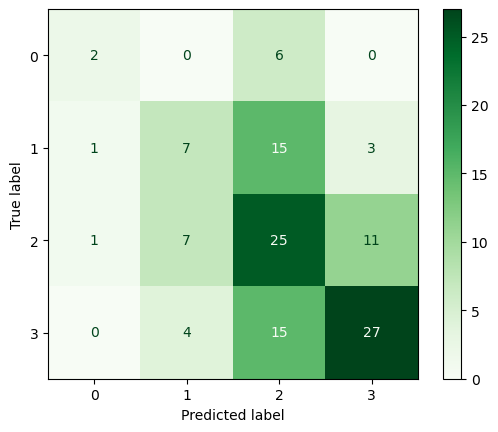

In [ ]:
# Evaluation
print(f"Classification Report:")
print(classification_report(y_test,
                            ypred_xgbft))
print(pd.DataFrame(confusion_matrix(y_test,
                                    ypred_xgbft)))
cm_xgb = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                    ypred_xgbft),
                               display_labels = model_xgbft.classes_)
cm_xgb.plot(cmap = "Greens")

Based on the classification report above, the overall accuracy score of the fine-tuned XGBoost model is 49%, with 49% precision, 42% recall, and 44% f1-score. These scores also indicates a slight improvement from the previous model, but the model still performed badly at predicting the cirrhosis stages.  

The precision score shows that only 49% of the predicted positive values are truly positive, while the recall score shows that 42% of the positive values are actually predicted positive. As a result, the F1-Score (44%) shows that the model's performance is horrible.  

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
2   2   114 6
```
**Class 2**

```
TP  FP  TN  FN
7   11  87  19
```
**Class 3**

```
TP  FP  TN  FN
25  36  44  19
```
**Class 4**

```
TP  FP  TN  FN
27  14  64  19
```

With the details provided above, the confusion matrix also shows that the model's predictions are rather gambled than really predict the result, since the true values (61) and the false values (63) are balanced.

### **EVALUATION**

#### **Random Forest : Accuracy Score**

In [ ]:
print(f"Accuracy Score : {accuracy_score(y_test, ypred_rfft) * 100:.2f}%")

Accuracy Score : 54.03%


#### **Random Forest : Classification Report**

In [ ]:
print(f"Classification Report :")
print(classification_report(y_test, ypred_rfft))

Classification Report :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      0.12      0.19        26
           2       0.45      0.75      0.56        44
           3       0.69      0.67      0.68        46

    accuracy                           0.54       124
   macro avg       0.43      0.38      0.36       124
weighted avg       0.54      0.54      0.49       124



c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Marcelline\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Random Forest : Confusion Matrix**

Confusion Matrix :


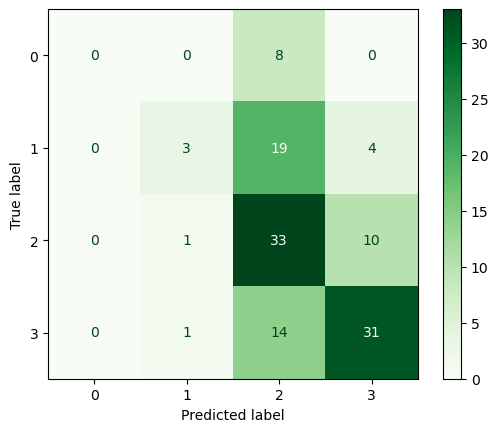

In [ ]:
print(f"Confusion Matrix :")
cm_rf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                   ypred_rfft),
                               display_labels = model_rfft.classes_)
cm_rf.plot(cmap = "Greens")

#### **Random Forest : Conclusion**

Based on the classification report above, the overall accuracy score of the fine-tuned Random Forest model is 54%, with 43% precision, 38% recall, and 36% f1-score. These scores indicates a slight improvement from the previous model, but the model still performed badly at predicting the cirrhosis stages.  

The precision score shows that only 43% of the predicted positive values are truly positive, while the recall score shows that 38% of the positive values are actually predicted positive. As a result, the F1-Score (36%) shows that the model's performance is horrible.  

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
0   0   116 8
```
**Class 2**

```
TP  FP  TN  FN
3   2   96  23
```
**Class 3**

```
TP  FP  TN  FN
33  41  39  11
```
**Class 4**

```
TP  FP  TN  FN
31  14  64  15
```

With the details provided above, the confusion matrix also shows that the model's predictions are rather gambled than really predict the result, since the true values (67) and the false values (57) are balanced.

As a conclusion, the Random Forest model is horrible at predicting the cirrhosis stage.

#### **XGBoost : Accuracy Score**

In [ ]:
print(f"Accuracy Score : {accuracy_score(y_test, ypred_xgbft) * 100:.2f}%")

Accuracy Score : 49.19%


#### **XGBoost : Classification Report**

In [ ]:
print(f"Classification Report :")
print(classification_report(y_test, ypred_xgbft))

Classification Report :
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.39      0.27      0.32        26
           2       0.41      0.57      0.48        44
           3       0.66      0.59      0.62        46

    accuracy                           0.49       124
   macro avg       0.49      0.42      0.44       124
weighted avg       0.50      0.49      0.49       124



#### **XGBoost : Confusion Matrix**

Confusion Matrix :


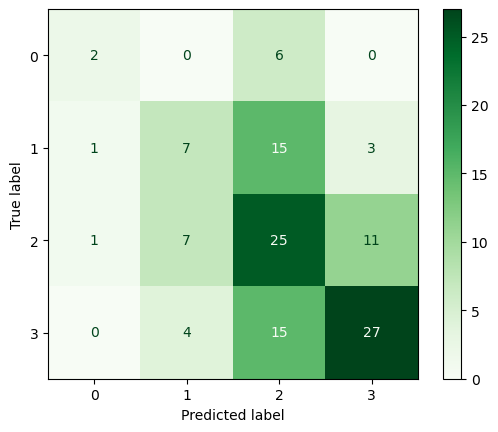

In [ ]:
print(f"Confusion Matrix :")
cm_xgb = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,
                                                                    ypred_xgbft),
                               display_labels = model_xgbft.classes_)
cm_xgb.plot(cmap = "Greens")

#### **XGBoost : Conclusion**

Based on the classification report above, the overall accuracy score of the fine-tuned XGBoost model is 49%, with 49% precision, 42% recall, and 44% f1-score. These scores also indicates a slight improvement from the previous model, but the model still performed badly at predicting the cirrhosis stages.  

The precision score shows that only 49% of the predicted positive values are truly positive, while the recall score shows that 42% of the positive values are actually predicted positive. As a result, the F1-Score (44%) shows that the model's performance is horrible.  

Confusion Matrix Details:  
**Class 1**

```
TP  FP  TN  FN
2   2   114 6
```
**Class 2**

```
TP  FP  TN  FN
7   11  87  19
```
**Class 3**

```
TP  FP  TN  FN
25  36  44  19
```
**Class 4**

```
TP  FP  TN  FN
27  14  64  19
```

With the details provided above, the confusion matrix also shows that the model's predictions are rather gambled than really predict the result, since the true values (61) and the false values (63) are balanced.

As a conclusion, the XGBoost model is also horrible at predicting the cirrhosis stage.

#### **Final Conclusion**

Both models performed poorly overall. If they had performed well in certain classes, it might have been due to an imbalanced target variable. However, since the poor performance spans across all classes, this suggests that the dataset itself is not well-suited for making predictions.

Furthermore, in my opinion, the cirrhosis dataset is too small, which limits the models from training effectively and learning meaningful patterns, which explains its horrible performance.

### **ANALYSIS**

#### **Random Forest : Feature Importance**

In [ ]:
dat = data.drop(columns = ["Stage"])

rf_imp = pd.DataFrame({
    "Feature": dat.columns,
    "Importance": model_rfft.feature_importances_
})

rf_imp = rf_imp.sort_values(by = "Importance", ascending = False)
rf_imp

,Feature,Importance
10,Tryglicerides,0.117007
12,Prothrombin,0.115590
5,Bilirubin,0.109272
6,Albumin,0.104105
3,Hepatomegaly,0.103332
11,Platelets,0.098012
7,Copper,0.086642
13,Age,0.081837
8,Alkaline Phospatase (U/L),0.079756
9,SGOT,0.068708


Based on the dataframe above, the most significant features for the prediction are **Tryglicerides**, **Prothrombin**, **Bilirubin**, **Albumin**, and **Hepatomegaly**.  
These features might be the cause of the horrible performance of the Random Forest model, because as mentioned above, some of these significant features only have slight correlation with the target variable (provided at the heatmap).

#### **XGBoost : Feature Importance**

In [ ]:
importance = model_xgbft.get_booster().get_score(importance_type = "gain")
xgb_imp = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Importance": list(importance.values())
})

xgb_imp = xgb_imp.sort_values(by = "Importance", ascending = False)
xgb_imp

,Feature,Importance
3,Hepatomegaly,1.230890
2,Ascites,0.475434
1,Gender,0.400555
7,Copper,0.372865
13,Age,0.340186
12,Prothrombin,0.328069
10,Tryglicerides,0.320588
5,Bilirubin,0.268708
6,Albumin,0.259443
0,Drug,0.232899


Based on the dataframe above, the most significant features for the prediction is **Hepatomegaly**, with the gain value of 1.23, meaning that this feature improves the model's loss function by 1.23 units.